In [20]:
class TechnologieWissen:
    def __init__(self, name: str, letzte_verwendung: int):
        self.name = name
        self.letzte_verwendung = letzte_verwendung

    def __repr__(self):
        return f"{self.name}: vor {self.letzte_verwendung} Tagen"

class MitarbeiterSkills:
    def __init__(self, name: str, technologien: list[TechnologieWissen]):
        self.name = name
        self.technologien = technologien

    def __repr__(self):
        technologien_str = "\n    ".join([repr(t) for t in self.technologien])
        return (
            f"Mitarbeiter:\n"
            f"  Name: {self.name}\n"
            f"  Skills:\n"
            f"    {technologien_str}"
        )

In [21]:
import json
import random

with open("technologien.json", "r", encoding="utf-8") as f:
    technologien = json.load(f)
with open("namen.json", "r", encoding="utf-8") as f:
    namen = json.load(f)

def get_random_skills():
    skills = []
    for _ in range(1, random.randint(1, 5) + 1):
        tech_name = random.choice(technologien)
        skills.append(TechnologieWissen(tech_name, random.randint(0, 2 * 365)))
    return skills

### Zufällige Farben für die Technologien generieren um den Plot später besser zu visualisieren

In [22]:
import matplotlib.colors as mcolors

def random_color():
    return [random.random(), random.random(), random.random()]

# Erzeuge für jede Technologie eine zufällige Farbe
tech_colors = {tech: random_color() for tech in technologien}

# Beispielausgabe
for tech, color in tech_colors.items():
    print(f"{tech}: {color}")


Python: [0.46344988167038736, 0.9493749108779758, 0.5170878404895152]
JavaScript: [0.22675039443323697, 0.24268873638715494, 0.6622588611595996]
Java: [0.0485732264951958, 0.778039396790416, 0.48395732066472774]
C#: [0.8252735337785191, 0.12139332055077989, 0.6378509227921901]
Ruby: [0.6848171182178513, 0.09916798332505006, 0.15242159869626193]
Go: [0.9363957432151584, 0.3513041238656588, 0.9242591138653787]
Rust: [0.26572543516450886, 0.4299068429942118, 0.25143738144955907]
Kotlin: [0.020185114347117006, 0.07113062328663966, 0.8919855450653852]
Swift: [0.7836647792250645, 0.48222951250383983, 0.3998103310625408]
PHP: [0.11133476317894342, 0.5776079848417968, 0.4594194462156178]
TypeScript: [0.9372838108897092, 0.16377484266182984, 0.5222183928762903]
Django: [0.1837325969560697, 0.6431241978467518, 0.7354584195884225]
Flask: [0.41221974971175923, 0.35555199185597175, 0.8985151154622668]
React: [0.2108557819467316, 0.5329949283649732, 0.8536925064763405]
Angular: [0.6714330835354022, 

## Formatieren der Daten

In [23]:
data = []

for name in namen:
    skills = get_random_skills()
    mitarbeiter = MitarbeiterSkills(name, skills)
    data.append(mitarbeiter)

for ma in data:
    print(ma)

Mitarbeiter:
  Name: Laura Müller
  Skills:
    JavaScript: vor 491 Tagen
    Tableau: vor 397 Tagen
Mitarbeiter:
  Name: Maximilian Schmidt
  Skills:
    MySQL: vor 8 Tagen
    Confluence: vor 570 Tagen
Mitarbeiter:
  Name: Anna Fischer
  Skills:
    TypeScript: vor 20 Tagen
    MySQL: vor 674 Tagen
    MLFlow: vor 159 Tagen
Mitarbeiter:
  Name: Jonas Wagner
  Skills:
    Jenkins: vor 45 Tagen
    Kotlin: vor 117 Tagen
Mitarbeiter:
  Name: Sofia Hofmann
  Skills:
    PyTorch: vor 532 Tagen
Mitarbeiter:
  Name: Paul Klein
  Skills:
    Google Cloud: vor 232 Tagen
Mitarbeiter:
  Name: Emma Lehmann
  Skills:
    Git: vor 550 Tagen
    TensorFlow: vor 262 Tagen
Mitarbeiter:
  Name: Liam Becker
  Skills:
    MySQL: vor 632 Tagen
Mitarbeiter:
  Name: Mia Krüger
  Skills:
    SQL: vor 199 Tagen
    PHP: vor 675 Tagen
    MLFlow: vor 82 Tagen
    Tableau: vor 87 Tagen
Mitarbeiter:
  Name: Noah Wolf
  Skills:
    PHP: vor 26 Tagen
    Ansible: vor 620 Tagen
    Google Cloud: vor 602 Tagen
Mita

## Erstellen der Vektoren (Embeddings)

In [24]:
from openai import OpenAI

client = OpenAI()

embedded_data = []

for ma in data:
    embedded_data.append(
        client.embeddings.create(input=str(ma), model="text-embedding-3-small").data[0].embedding
    )

## Erstellen der Vektordatenbank

In [25]:
import faiss
import numpy as np

dim = len(embedded_data[0])
index = faiss.IndexFlatL2(dim)

embeddings_np = np.array(embedded_data).astype("float32")
index.add(embeddings_np)

## Suche in der Vektordatenbank

In [29]:
query = "Java Backend in den letzten 5 Monaten"
query_vector = client.embeddings.create(input=query, model="text-embedding-3-small").data[0].embedding

search_vector = np.array([query_vector]).astype('float32')

erg_anzahl = 5

D, indices = index.search(search_vector, erg_anzahl)

print(f"Distances: {D}")
print(f"Indices: {indices}")

for i in indices[0]:
    print(data[i])

Distances: [[0.9015419  0.90527076 0.92429113 0.93241864 0.9343407 ]]
Indices: [[114  46 217  92 140]]
Mitarbeiter:
  Name: Kai Köhler
  Skills:
    JavaScript: vor 275 Tagen
    Java: vor 713 Tagen
    PostgreSQL: vor 209 Tagen
Mitarbeiter:
  Name: Max Neumann
  Skills:
    Java: vor 583 Tagen
    Python: vor 558 Tagen
    Django: vor 523 Tagen
    Bitbucket: vor 638 Tagen
    Kotlin: vor 688 Tagen
Mitarbeiter:
  Name: Jannick Konrad
  Skills:
    Google Cloud: vor 54 Tagen
    Jenkins: vor 258 Tagen
    NumPy: vor 412 Tagen
    MySQL: vor 98 Tagen
    Angular: vor 346 Tagen
Mitarbeiter:
  Name: Chris Bergmann
  Skills:
    Java: vor 505 Tagen
    Terraform: vor 131 Tagen
    TypeScript: vor 5 Tagen
    Python: vor 55 Tagen
    Scikit-learn: vor 422 Tagen
Mitarbeiter:
  Name: Jörg Weber
  Skills:
    Angular: vor 559 Tagen
    React: vor 207 Tagen
    Django: vor 386 Tagen
    Express.js: vor 22 Tagen


## Darstellen mit t-SNE

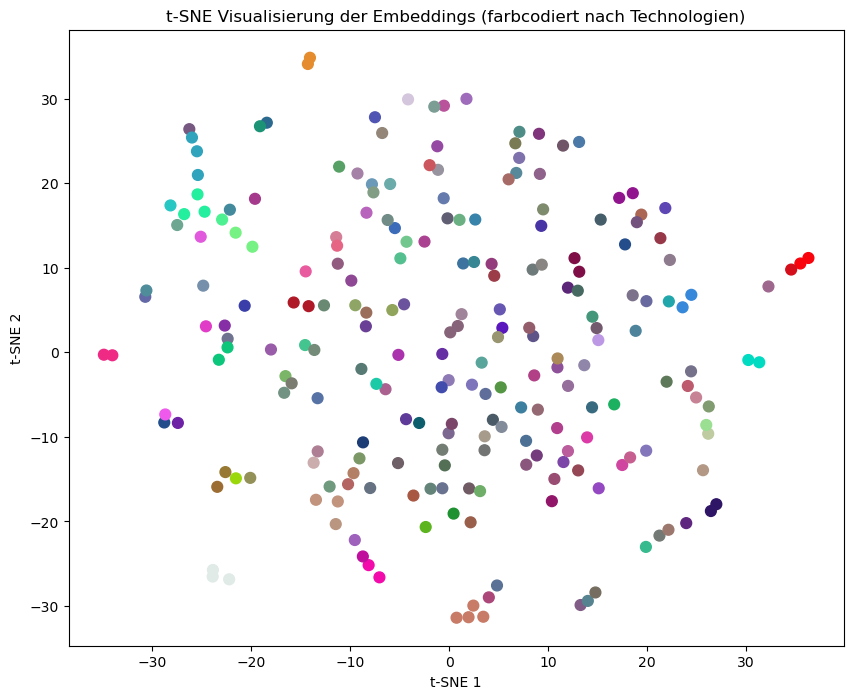

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Wende t-SNE an (perplexity < n_samples, z.B. 10)
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
reduced_embeddings = tsne.fit_transform(embeddings_np)

# Berechne für jeden Mitarbeiter die Mischfarbe seiner Technologien
def mix_colors(techs):
    colors = [tech_colors[t.name] for t in techs if t.name in tech_colors]
    if colors:
        return np.mean(colors, axis=0)
    else:
        return [0.5, 0.5, 0.5]  # Grau als Fallback

point_colors = [mix_colors(ma.technologien) for ma in data]

# Plotten der reduzierten Embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=60, c=point_colors)

# Optional: Titel und Achsenbeschriftungen hinzufügen
plt.title("t-SNE Visualisierung der Embeddings (farbcodiert nach Technologien)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.show()